In [2]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader

In [3]:
with open('./yolov5/data/coco128.yaml', mode='r') as f:
    data_yaml = yaml.load(f, SafeLoader)

labels = data_yaml['names']
labels

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [27]:
yolo = cv2.dnn.readNetFromONNX('./yolov5/runs/train/exp32/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

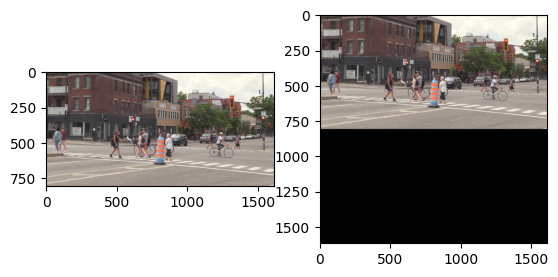

In [74]:
import matplotlib.pyplot as plt

img = cv2.imread('image1-1.png')
image = img.copy()

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(image[:,:,::-1])

h,w,d = image.shape

# Square Image
max_dimension = max(h,w)
input_image = np.zeros((max_dimension, max_dimension,3), dtype=np.uint8)
input_image[:h, :w, :] = image
plt.subplot(1,3,2)
plt.imshow(input_image[:,:,::-1])
plt.show()

YOLO_WIDTH = 640
blob = cv2.dnn.blobFromImage(input_image, 1/255, (YOLO_WIDTH, YOLO_WIDTH), swapRB=True, crop=False)
yolo.setInput(blob)
preds = yolo.forward()

In [75]:
# center_x + center_y + width + height + confidence + 80classes
# 25200 bounding boxes
preds.shape

(1, 25200, 85)

In [76]:
# Non max supression
detections = preds[0]
boxes = []
confidences = []
classes = []

image_w, image_h = input_image.shape[:2]
x_scale = image_w/YOLO_WIDTH
y_scale = image_h/YOLO_WIDTH

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4]
    if confidence > 0.4:
        class_score = row[5:].max()
        class_id = row[5:].argmax()

        if class_score > 0.25:
            cx, cy, pred_w, pred_h = row[:4]
            # Create bounding box
            xmin = (cx-pred_w/2) * x_scale
            ymin = (cy-pred_h/2) * y_scale
            b_w = pred_w * x_scale
            b_h = pred_h * y_scale

            boxes.append([xmin, ymin, b_w, b_h])
            classes.append(class_id)
            confidences.append(confidence)

# NMS
index = cv2.dnn.NMSBoxes(boxes, confidences, 0.25, 0.45)

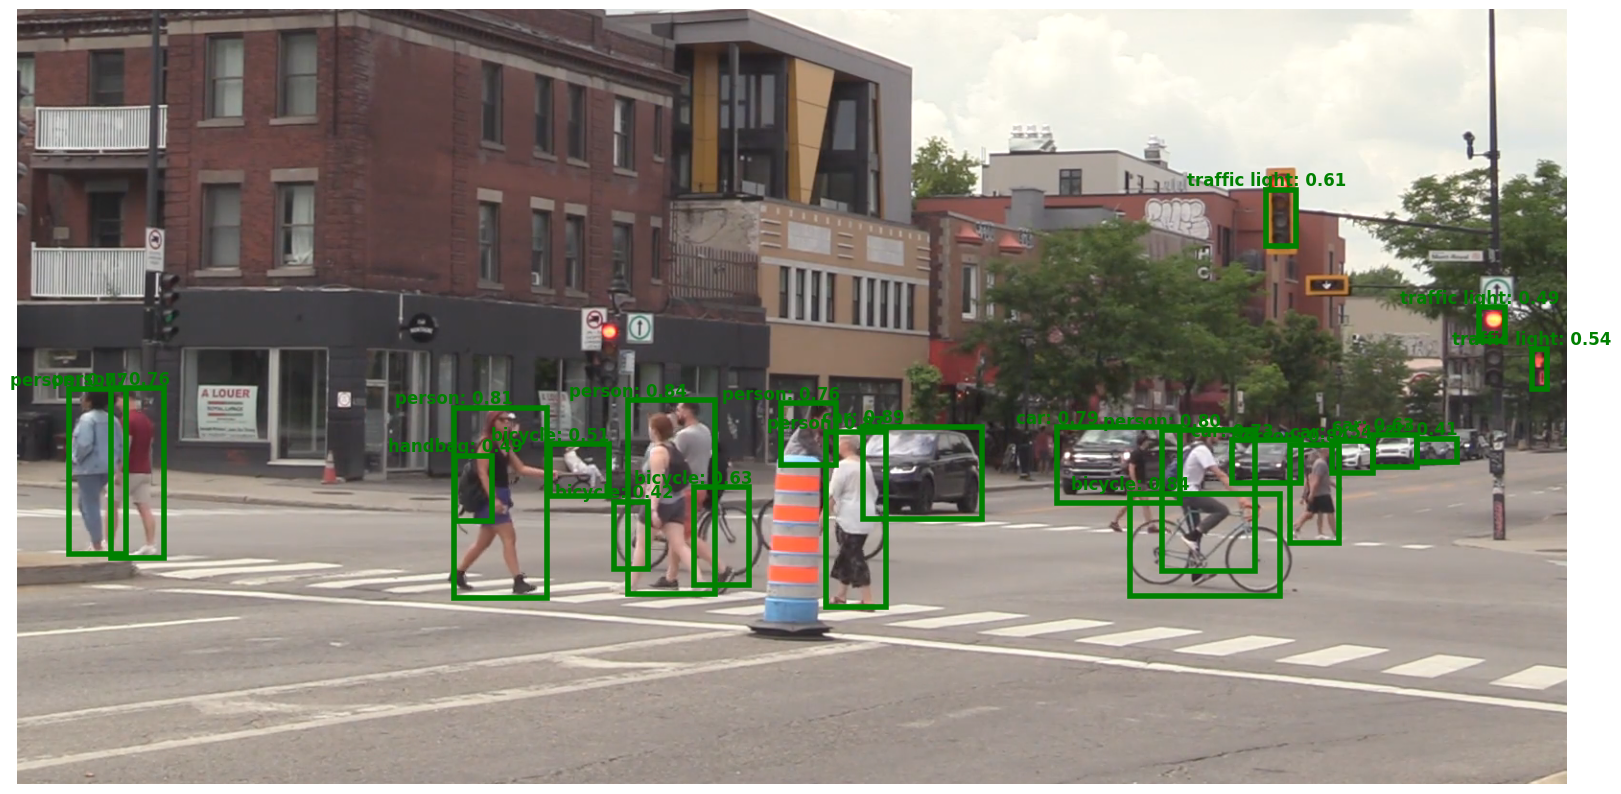

In [77]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
for ind in index:
    x,y,w,h = boxes[ind]
    conf = confidences[ind]
    class_id = classes[ind]
    class_name = labels[class_id]

    text = f'{class_name}: {conf:.2f}'

    rect = Rectangle((x,y), w,h, 
                     linewidth=4, edgecolor='g', facecolor='none')
    plt.gca().add_patch(rect)

    plt.text(x,y-10, text,
             horizontalalignment='center', verticalalignment='center',
             fontsize=12, color='g', weight='bold')
plt.axis(False)
plt.show()